In [108]:
import os
import time
import glob
import math
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing, model_selection
%matplotlib inline

In [109]:
os.environ["KERAS_BACKEND"] = 'tensorflow'
import keras

In [110]:
data_dir = "generated_games"

In [111]:
print("CSVs in data_dir:")
files = glob.glob(os.path.join(data_dir, "*.csv"))
print([os.path.basename(file) for file in files])

CSVs in data_dir:
['random_choice_games.csv']


In [112]:
fp = os.path.join(data_dir, "random_choice_games.csv")
raw = pd.read_csv(fp)

In [113]:
winning_moves = raw.groupby("game_no").last()

In [114]:
boards = []
for i, row in winning_moves.iterrows():
    board_rows = []
    for j in range(6):
        seg = row.iloc[j*7:(j+1)*7]
        seg = seg.values#.reshape(-1, 1)
        board_rows.append(seg)
    boards.append(np.array(board_rows))

In [115]:
X = np.array(boards)
X.shape

(50000, 6, 7)

In [116]:
y = winning_moves["choice"].values

In [117]:
# https://github.com/dcoxnard/nyc17_ds13/blob/master/class_lectures/week08-fletcher2/03-deep_learning_keras/Deep%20Learning%20for%20NLP-%20An%20Application-based%20Intro.ipynb

test_share = .25

ix = math.floor(X.shape[0] * test_share)
X_train = X[:ix]
X_test = X[ix:]
y_train = y[:ix]
y_test = y[ix:]

In [127]:
input_shape = (6, 7, 1)

input_ = keras.layers.Input(input_shape)
print(input_.shape)
x = keras.layers.Conv2D(6, (2, 2), activation='relu', input_shape=input_shape, data_format='channels_last')(input_)
print(x.shape)
x = keras.layers.MaxPool2D(pool_size=(1, 1), data_format='channels_last')(x)
print(x.shape)
x = keras.layers.BatchNormalization()(x)
print(x.shape)
x = keras.layers.Flatten()(x)
print(x.shape)
x = keras.layers.Dense(32, activation='relu')(x)
print(x.shape)
output = keras.layers.Dense(7, activation='softmax')(x)
model = keras.Model(input_, output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

(?, 6, 7, 1)
(?, 5, 6, 6)
(?, 5, 6, 6)
(?, 5, 6, 6)
(?, ?)
(?, 32)


In [128]:
start = time.time()
history = model.fit(X_train.reshape(12500, 6, 7, 1), y_train, epochs=200, batch_size=64, validation_split=.25, verbose=0);
end = time.time()
print(f"Model fit in {round(end - start, 3)} secs")

Model fit in 217.274 secs


C:\Users\David\Anaconda3\envs\Connect-Four\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


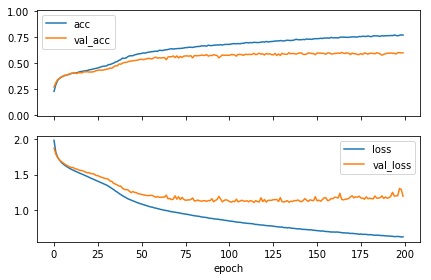

In [129]:
measures = np.unique([k.replace('val_', '') for k in history.history.keys()])
n = len(measures)
x = np.arange(len(history.history[measures[0]]))
fig, axs = plt.subplots(n, 1, squeeze=True, sharex=True, figsize=(6, 2*n), tight_layout=True)
for i, m in enumerate(measures):
    axs[i].plot(x, history.history[m], label=m)
    if f"val_{m}" in history.history.keys():
        axs[i].plot(x, history.history[f"val_{m}"], label=f"val_{m}")
    if m == "acc":
        axs[i].set_ylim((-0.01, 1.01))
    axs[i].legend()
axs[-1].set_xlabel("epoch");